# Machine Learning HW3 Simulation Part (1st exercise)
## Amirmahdi Ansaripour (810198358)

In [4]:
# import tensorflow.keras as ts
import pandas as pds
# from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

lRate = 0.001
test_ratio = 0.1
batchsize = 40
num_of_classes = 4

datapath = './ECG.csv'
df = pds.read_csv(datapath)

In [6]:
def divide_into_test_and_train(x, y, ratio):
    x_train, x_test, y_train, y_test = train_test_split(x, y, stratify = LabelEncoder().fit_transform(y),
                    test_size = ratio, random_state = 0)
    return x_train, x_test, y_train, y_test

def show_freqs(value, title):
    df_temp = pds.DataFrame({'freq': value})
    df_temp.groupby('freq').size().plot(kind='bar')
    plt.xlabel('Classes')
    plt.ylabel('Frequency')
    plt.title(title)
    plt.show()
    return
    

In [19]:
def convert_to_num(categories):
    num = []
    for i in range(len(categories)):
        if categories.iloc[i] == 'A':
            num.append(0)
        elif categories.iloc[i] == 'N':
            num.append(1)
        elif categories.iloc[i] == 'O':
            num.append(2)
        else:
            num.append(3)
    return num
    
def oneHot(y_values):
    numerics = convert_to_num(y_values)
    array = np.array(numerics)
    oneHotted = np.zeros((len(numerics), num_of_classes))
    oneHotted[np.arange(array.size),array] = 1
    print(oneHotted)
#     print(labels.iloc[0])
#     print(oneHotted[0])
    return oneHotted

In [14]:
def standardize(dataset):
    for col in dataset.columns:
        dataset[col] = ((dataset[col] - dataset.mean()[col]) / dataset.var()[col])
    return dataset

def feedForward(firstLayerNuerons, secondLayerNuerons, thirdLayerNuerons, forthLayerNuerons, function):
    inputLayer = ts.layers.Input(x_train.iloc[0].shape)
    outputLayer = ts.layers.Flatten()(inputLayer)
    
    outputLayer = ts.layers.Dense(firstLayerNuerons, activation = function, kernel_regularizer = None)(inputLayer)
    outputLayer = ts.layers.Dense(secondLayerNuerons, activation = function, kernel_regularizer = None)(outputLayer)
    outputLayer = ts.layers.Dense(thirdLayerNuerons, activation = function, kernel_regularizer = None)(outputLayer)
    outputLayer = ts.layers.Dense(forthLayerNuerons, activation = function, kernel_regularizer = None)(outputLayer)
    
    outputLayer = ts.layers.Dense(num_of_classes, activation = 'softmax', kernel_regularizer = None)(outputLayer)
    NN = ts.Model(inputLayer, outputLayer)
    return NN


def analyze_model(model, train, test, Optimizer, loss_function, num_of_epochs):
    model.compile(optimizer = Optimizer, loss = loss_function, metrics = ['accuracy'])
    model.summary()
    results = model.fit(train, one_hotted_y_train,
                        batch_size = batchsize, validation_data = (test, one_hotted_y_test), epochs = num_of_epochs)

In [15]:
def plot_confusion_matrix(model, labels):
    y_pred = model.predict(x_test)
    y_correct = convert_to_num(y_test) # [0, 0, 1, 3, 2, 1] based on number of classes
    y_pred_modified = []
    for i in range(len(y_pred)):
        pred_label = np.argmax(y_pred[i])
        y_pred_modified.append(pred_label)
    matrix = confusion_matrix(y_correct, y_pred_modified)
    plt.figure(figsize = (num_of_classes, num_of_classes))
    sns.heatmap(matrix, cmap=plt.cm.Blues, xticklabels = labels, yticklabels = labels, annot = True, fmt = 'd')
    plt.xlabel('Predictions')
    plt.ylabel('Actuals')
    plt.show()
    print(classification_report(y_correct, y_pred_modified))

## Part A: (number of samples in each class)
Each class's size is mentioned by using the value_counts() method

In [10]:
num_of_classes = 4
df = df.drop(df.columns[0], axis = 1)
df['label'].value_counts()

N    5992
O    3151
A     923
~     187
Name: label, dtype: int64

## Part B: (histogram of classes)
The histogram of the four classes existing in the dataset is shown in the following section. The low population of noisy class, whose label is ~, causes predicting this class difficult. Because there are few samples of this class, the designed model cannot learn its features appropriately. On the other hand, due to the high frequency of class N, this label will be the dominant prediction when predicting the test set.

As a result, the model does not predict test samples belonging to ~ class, and puts N labels on wrong samples repeatedly. 

In [11]:
labels = df.iloc[:, 0]
features = df.iloc[:, 1:]
x_train, x_test, y_train, y_test = divide_into_test_and_train(features, labels, test_ratio)

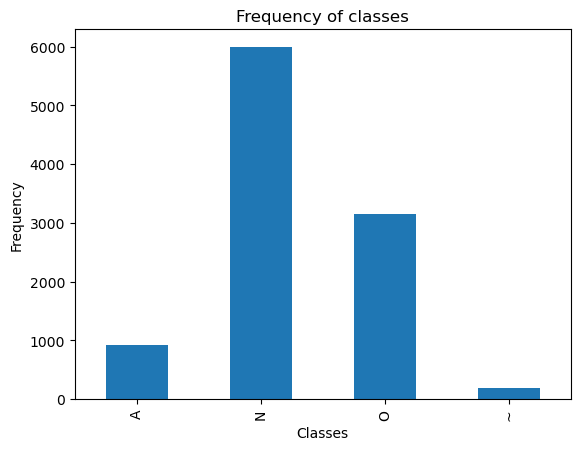

In [12]:
show_freqs(df['label'], 'Frequency of classes')

In [20]:
one_hotted_y_train = oneHot(y_train)
one_hotted_y_test = oneHot(y_test)

[[0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 ...
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]]
[[0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 ...
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]]


## Part C: (outputs when no preprocessing is done)
In this part, the dataset is given to the nueral network without any preprocessing. The most significant problem of not applying normalization is that the attributes whose scales are greater than others will affect the weights' values more drastically.

As a result, the model will be biassed towards those attributes and ignore other features, which may be as important, in its prediction.

As explained before, the model performs better for class N than others, and performs poorly for class ~. The main reason is the high frequency of N samples and low frequency of ~ samples in the training set.


Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 169)]             0         
                                                                 
 dense_30 (Dense)            (None, 100)               17000     
                                                                 
 dense_31 (Dense)            (None, 64)                6464      
                                                                 
 dense_32 (Dense)            (None, 128)               8320      
                                                                 
 dense_33 (Dense)            (None, 64)                8256      
                                                                 
 dense_34 (Dense)            (None, 4)                 260       
                                                                 
Total params: 40,300
Trainable params: 40,300
Non-trainable

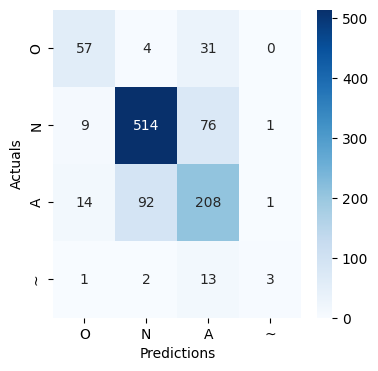

              precision    recall  f1-score   support

           0       0.70      0.62      0.66        92
           1       0.84      0.86      0.85       600
           2       0.63      0.66      0.65       315
           3       0.60      0.16      0.25        19

    accuracy                           0.76      1026
   macro avg       0.69      0.57      0.60      1026
weighted avg       0.76      0.76      0.76      1026



In [51]:
NN = feedForward(firstLayerNuerons = 100, secondLayerNuerons = 64, thirdLayerNuerons = 128, forthLayerNuerons = 64, function = 'relu')
analyze_model(model = NN, train = x_train, test = x_test, Optimizer = ts.optimizers.Adam(learning_rate = lRate), loss_function = 'categorical_crossentropy', num_of_epochs = 80)
plot_confusion_matrix(NN, ['O', 'N', 'A', '~'])

## Part D: (outputs when features are standardized)
Based on the standardization formula:

$\vec{X} = \frac{\vec{X} - mean(\vec{X})}{var(\vec{X})} $

We now make the scale of each feature relatively equal, causing the model to pay attention to all features. As it can be concluded in the confusion matrix and the classification report, the model's accuracy increases significantly. 

In addition, other detailed parameters related to each class increase too. For example, the accuracy of O and ~ classes increases drastically. This is because all features have equal shares in the model's prediction.



Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 169)]             0         
                                                                 
 dense_35 (Dense)            (None, 100)               17000     
                                                                 
 dense_36 (Dense)            (None, 64)                6464      
                                                                 
 dense_37 (Dense)            (None, 128)               8320      
                                                                 
 dense_38 (Dense)            (None, 64)                8256      
                                                                 
 dense_39 (Dense)            (None, 4)                 260       
                                                                 
Total params: 40,300
Trainable params: 40,300
Non-trainable

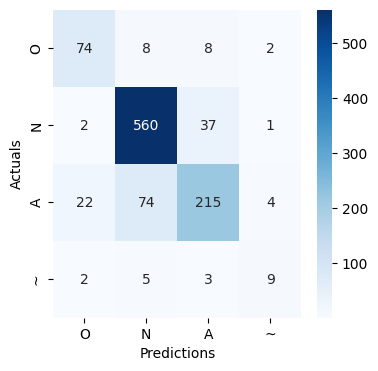

              precision    recall  f1-score   support

           0       0.74      0.80      0.77        92
           1       0.87      0.93      0.90       600
           2       0.82      0.68      0.74       315
           3       0.56      0.47      0.51        19

    accuracy                           0.84      1026
   macro avg       0.75      0.72      0.73      1026
weighted avg       0.83      0.84      0.83      1026



In [52]:
standardized_x_train = standardize(x_train)
standardized_x_test = standardize(x_test)
NN = feedForward(firstLayerNuerons = 100, secondLayerNuerons = 64, thirdLayerNuerons = 128, forthLayerNuerons = 64, function = 'relu')
analyze_model(model = NN, train = standardized_x_train, test = standardized_x_test, Optimizer = ts.optimizers.Adam(learning_rate = lRate), loss_function = 'categorical_crossentropy', num_of_epochs = 80)
plot_confusion_matrix(NN, ['O', 'N', 'A', '~'])

## Part E: (outputs when the noisy class is removed, and two less popluted classes are merged)
In this part, the noisy class (labeled ~) is omitted. Also, classes O and A are merged into one class representing abnormal samples. Therefore, the task converts into a binary classification. 

Moreover, since there are adequate samples in each class, the network will learn the patterns and details distinguishing A and N. As a result, the accuracy of model on test samples will increase.

In [53]:
num_of_classes = 2
df = df[df['label'] != '~']
df['label'] = df['label'].replace(to_replace='O', value='A', regex=True)
df['label'].value_counts()

N    5992
A    4074
Name: label, dtype: int64

Now we only have two labels, Normal and Abnormal samples.

In [54]:
labels = df.iloc[:, 0]
features = df.iloc[:, 1:]
x_train, x_test, y_train, y_test = divide_into_test_and_train(features, labels, test_ratio)

In [55]:
one_hotted_y_train = oneHot(y_train)
one_hotted_y_test = oneHot(y_test)
x_train = standardize(x_train)
x_test = standardize(x_test)

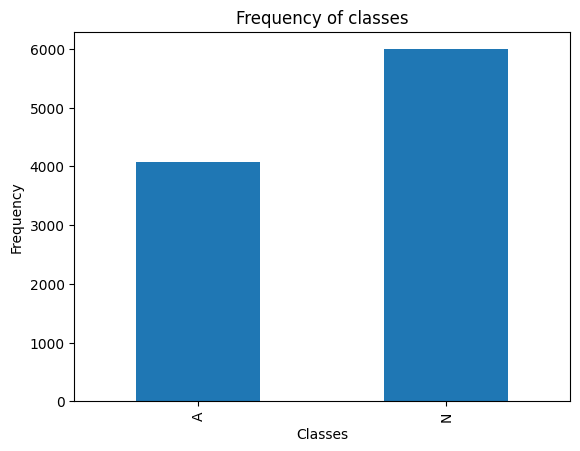

In [56]:
show_freqs(df['label'], 'Frequency of classes')

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 169)]             0         
                                                                 
 dense_40 (Dense)            (None, 100)               17000     
                                                                 
 dense_41 (Dense)            (None, 64)                6464      
                                                                 
 dense_42 (Dense)            (None, 128)               8320      
                                                                 
 dense_43 (Dense)            (None, 64)                8256      
                                                                 
 dense_44 (Dense)            (None, 2)                 130       
                                                                 
Total params: 40,170
Trainable params: 40,170
Non-trainable

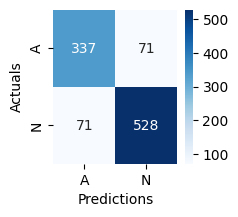

              precision    recall  f1-score   support

           0       0.83      0.83      0.83       408
           1       0.88      0.88      0.88       599

    accuracy                           0.86      1007
   macro avg       0.85      0.85      0.85      1007
weighted avg       0.86      0.86      0.86      1007



In [57]:
NN = feedForward(firstLayerNuerons = 100, secondLayerNuerons = 64, thirdLayerNuerons = 128, forthLayerNuerons = 64, function = 'relu')
analyze_model(model = NN, train = x_train, test = x_test, Optimizer = ts.optimizers.Adam(learning_rate = lRate), loss_function = 'categorical_crossentropy', num_of_epochs = 80)
plot_confusion_matrix(NN, ['A', 'N'])